In [1]:
# Brent

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import r2_score

#### Load and Cleanse csv into Dataframe

In [3]:
df = pd.read_csv('./brent_price.csv')
# date is not date transform it into datetime
df['date'] = pd.to_datetime(df['DATE'])
df.dtypes
len_dataframe = len(df)
print(len_dataframe)

4587


In [4]:
df.describe()

,DCOILBRENTEU
count,4587.000000
mean,75.458886
std,25.245634
min,9.120000
25%,56.095000
50%,70.550000
75%,98.640000
max,143.950000


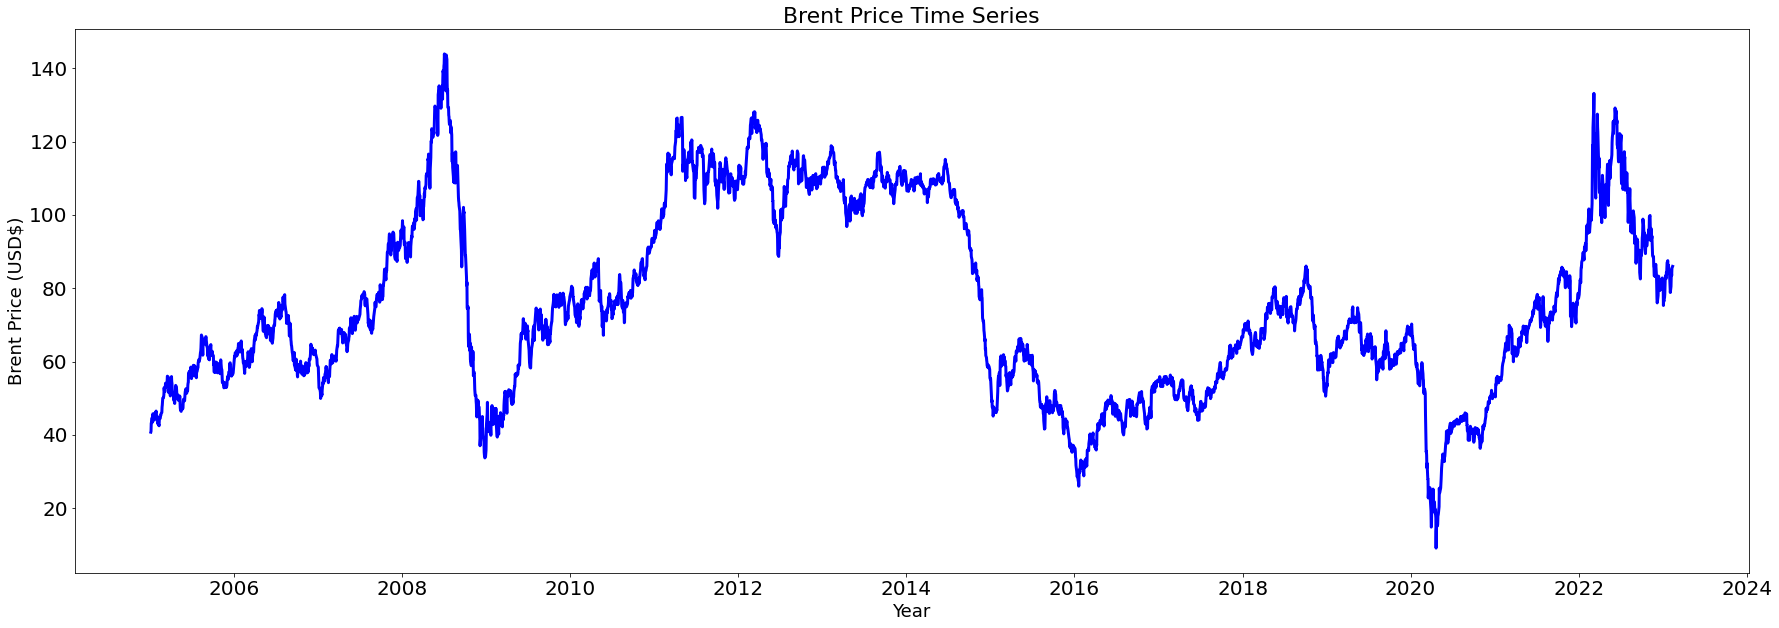

In [5]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))


ax.plot(df['date'],df['DCOILBRENTEU'],color='blue',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

#### Time Series Decomposition to analyze Seasonality and Trend

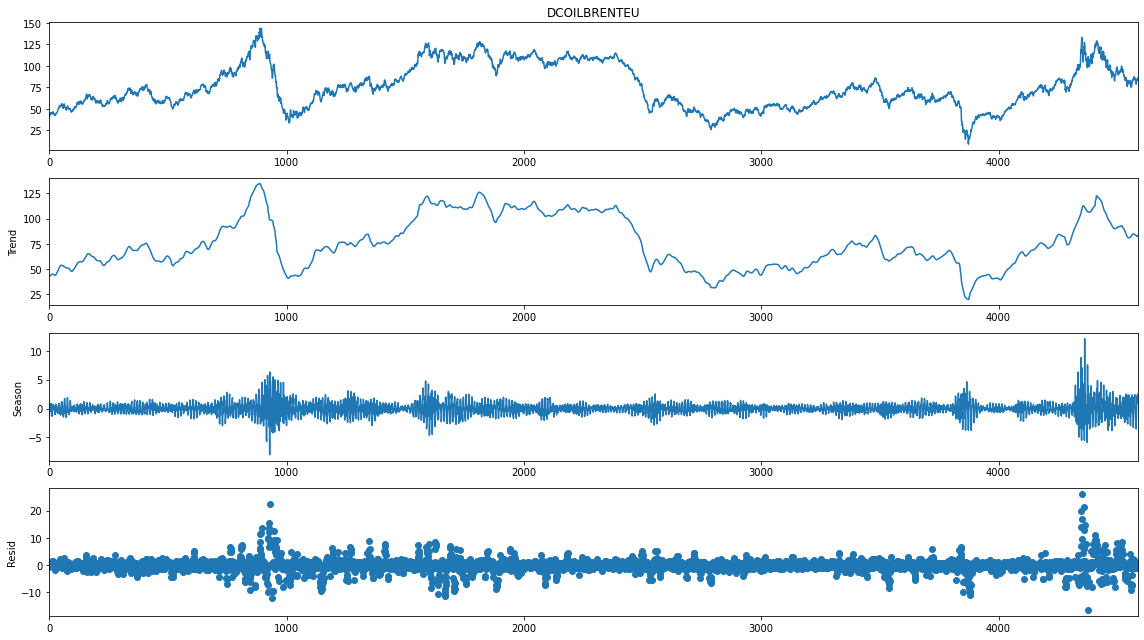

In [6]:
plt.rcParams["figure.figsize"] = [16,9]
stl = STL(df['DCOILBRENTEU'], period=12, robust=True)
result = stl.fit()
result.plot() 
plt.show()

In [7]:
# Time series is clearly without seasonality and trend
# We transform the prediction into a supervised learning approach
# <steps> - <prediction>
# How many steps can perform a horizon prediction?
ahead = 3     # we will perform at 90 days
steps = 200      # we use 10 steps as an example
length = len(df)

print('Number of steps (shape)', df.shape)
# we create a numpy array with all the steps
prices = df[["DCOILBRENTEU"]].to_numpy()

Number of steps (shape) (4587, 3)


In [8]:
s = prices
lvect = []
ahead = 1
lag = 10
trainsize = len(s)
lvect = []
lvect2 = []
for i in range(lag, trainsize-lag-ahead):
   lvect.append(s[i:i+lag-1])
   lvect2.append(s[i+ahead+lag-1])   
X = np.stack(lvect, axis=1)
y = np.stack(lvect2, axis=1)
y = np.swapaxes(y, 1,0)
X = np.swapaxes(X, 0, 1)
X = np.squeeze(X)
y = np.squeeze(y)

In [9]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("=============================================================")

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (3652, 9)  y_training: :  (3652,)
shape x_test     :  (914, 9)  y_test      :  (914,)


In [11]:
XGB = xgb.XGBRegressor()
XGB.fit(train_x, train_y)
y_hat = XGB.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.9899280625984964
MAPE Value: 0.025188125697691636


In [12]:
#Create a column for y_hat
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, y_hat))
prevision = np.concatenate((prevision, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(prevision)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, prevision))
df['prevision'] = prevision
df['prevision'] = df['prevision'].astype(float)

In [23]:
#Create a column for y_test
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, test_y))
zz = np.concatenate((zz, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(zz)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, zz))
df['zz'] = zz
df['zz'] = df['zz'].astype(float)

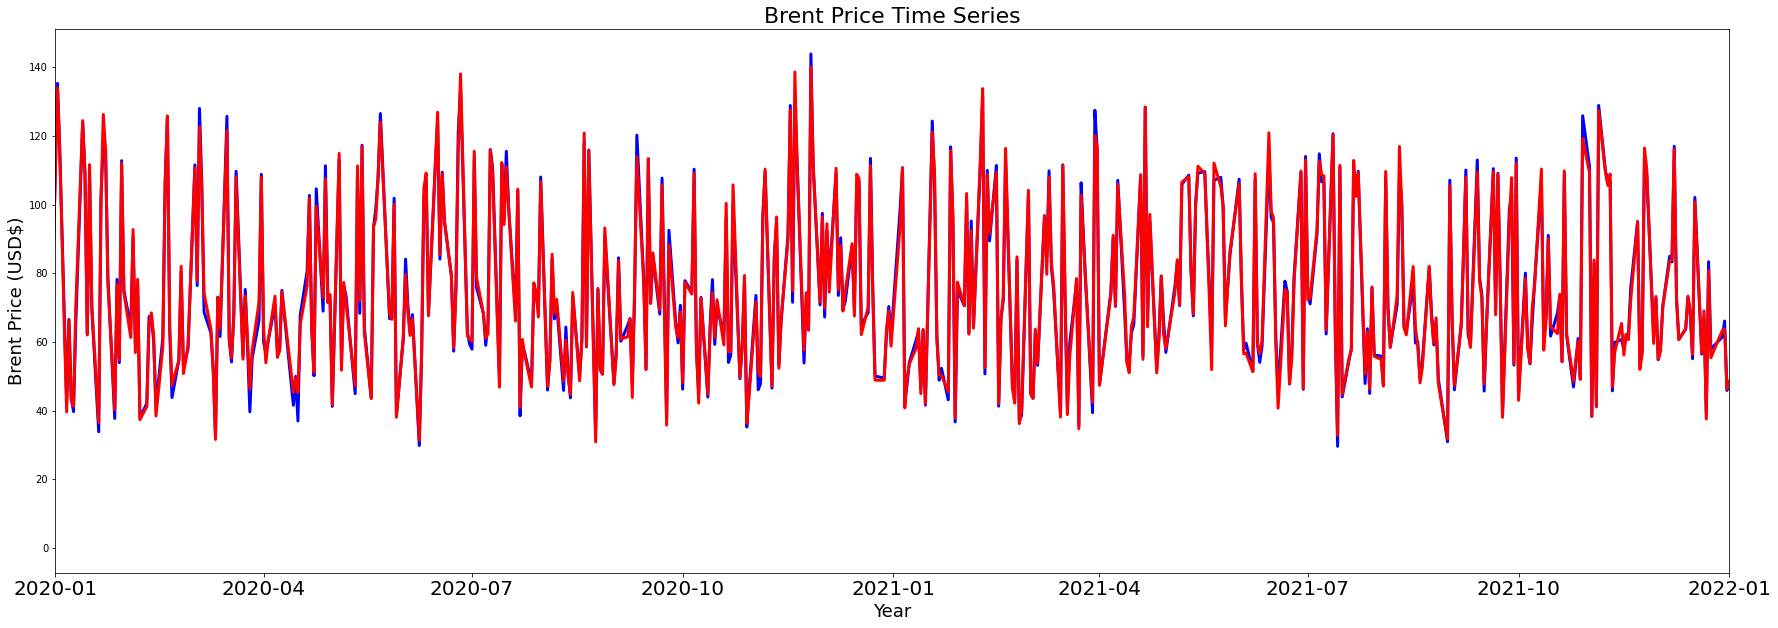

In [24]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df['date'],df['zz'],color='blue',linewidth=3.0)
ax.plot(df['date'],df['prevision'],color='red',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.xlim('2020','2022')
#plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

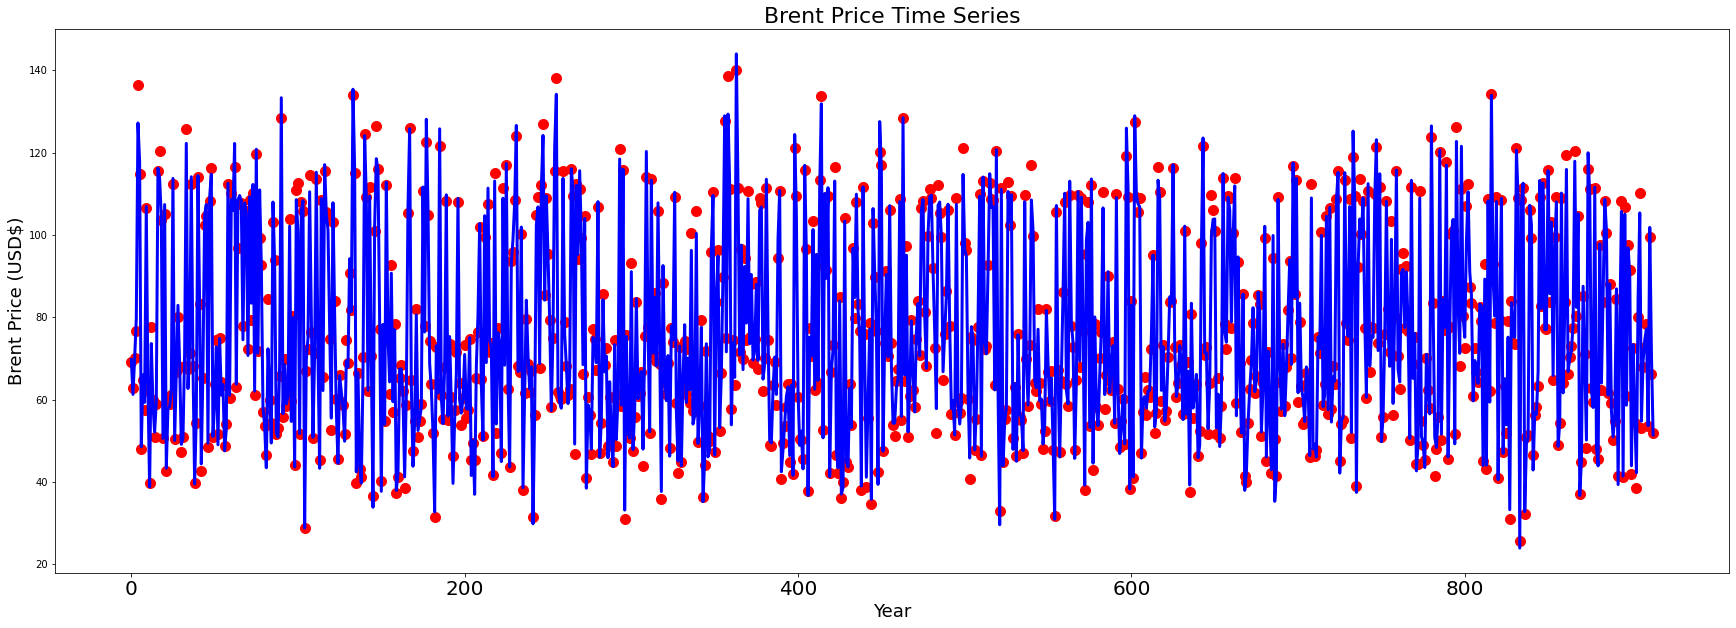

In [15]:


X = np.arange(len(y_hat))

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(test_y,color='blue',linewidth=3.0)
#ax.plot(y_hat,color='blue',linewidth=3.0)
ax.scatter(X, y_hat,color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)

#plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

In [22]:
df.tail(200)

,DATE,DCOILBRENTEU,date,prevision,zz
4387,2022-04-29,108.36,2022-04-29,108.734190,108.734190
4388,2022-05-03,104.94,2022-05-03,115.557976,115.557976
4389,2022-05-04,110.53,2022-05-04,45.117410,45.117410
4390,2022-05-05,112.11,2022-05-05,54.221940,54.221940
4391,2022-05-06,113.86,2022-05-06,55.105564,55.105564
...,...,...,...,...,...
4582,2023-02-07,82.92,2023-02-07,0.000000,0.000000
4583,2023-02-08,84.17,2023-02-08,0.000000,0.000000
4584,2023-02-09,83.46,2023-02-09,0.000000,0.000000
4585,2023-02-10,85.46,2023-02-10,0.000000,0.000000


In [20]:
y_hat

array([ 69.22146 ,  62.890667,  70.05819 ,  76.587074, 136.36493 ,
       114.677734,  48.129574,  64.7045  ,  57.608215, 106.541214,
        62.019276,  39.86948 ,  77.55487 ,  59.906254,  51.067596,
        58.869293, 115.41847 , 120.28293 , 103.63835 ,  50.718178,
       105.04798 ,  42.79574 ,  60.5371  ,  58.900166,  61.092487,
       112.29011 ,  50.47476 ,  66.658134,  79.986   ,  67.87487 ,
        47.22575 ,  51.054344,  68.21663 , 125.815544,  67.3475  ,
        71.43386 , 112.39445 ,  68.0731  ,  39.839195,  54.2288  ,
       114.085045,  83.29601 ,  42.57584 ,  65.27884 , 102.35079 ,
       104.54746 ,  48.63788 , 108.34587 , 116.30655 ,  50.997543,
        63.919186,  74.38322 ,  51.79515 ,  74.95737 ,  64.19073 ,
        63.45746 ,  48.774544,  54.088688, 112.45532 ,  60.447884,
       110.154366, 107.04084 , 116.450745,  63.144196,  96.89422 ,
       107.53395 , 107.76085 ,  77.860374, 103.547676, 105.70401 ,
        72.362595, 108.429855,  79.39651 , 110.10603 ,  61.186

In [21]:
test_y

array([ 69.75,  61.28,  69.93,  79.62, 127.18, 117.74,  48.59,  66.03,
        59.35, 106.9 ,  62.26,  38.84,  73.63,  58.8 ,  52.1 ,  59.46,
       116.23, 113.69, 104.55,  50.59, 107.37,  43.37,  57.89,  58.25,
        62.43, 113.74,  50.12,  66.79,  82.92,  68.94,  49.18,  50.61,
        71.56, 122.23,  62.72,  72.18, 114.13,  68.85,  39.54,  55.97,
       114.43,  82.91,  44.41,  67.65, 104.77, 107.39,  49.45, 109.1 ,
       114.75,  51.05,  59.32,  72.86,  49.06,  74.87,  61.12,  63.67,
        47.58,  52.84, 112.53,  61.09, 108.62, 105.95, 122.21,  63.77,
       108.49, 109.57, 108.25,  74.56, 107.8 , 105.41,  70.73, 109.28,
        83.43, 112.26,  62.09, 120.8 ,  71.3 , 110.93,  93.11,  58.1 ,
        53.68,  43.48,  72.37,  62.13,  49.49, 107.99,  93.23,  51.87,
        50.95,  68.73, 133.31,  56.62,  68.48,  58.97,  60.9 , 102.14,
        54.72,  79.91,  43.68, 108.56, 100.81,  51.76, 105.73, 108.32,
        28.84,  69.71,  74.86, 110.48,  81.11,  50.88,  71.5 , 115.22,
      